In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, classification_report, roc_auc_score, confusion_matrix, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import optuna
from optuna.samplers import TPESampler
import warnings
warnings.filterwarnings('ignore')

In [8]:
# Import XGBoost if available - handle gracefully if not
try:
    import xgboost as xgb
    xgboost_available = True
except ImportError:
    print("XGBoost not installed. Skipping XGBoost models.")
    xgboost_available = False

def load_and_preprocess_data():
    """Load and preprocess the neuroimaging data."""
    print("Loading datasets...")
    try:
        # Load the data
        X_train_of = pd.read_csv('X_train_of.csv')
        X_val_of = pd.read_csv('X_val_of.csv')
        test_of = pd.read_csv('test_of.csv')
        train_matrice = pd.read_csv('TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv')
        test_matrice = pd.read_csv('TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv')
        
        # Load outcome for classification
        outcome = pd.read_excel("TRAINING_SOLUTIONS.xlsx")
        outcome.set_index('participant_id', inplace=True)
        
        # Drop target columns from train_matrice
        columns_to_drop = ['Sex_F', 'ADHD_Outcome']
        train_matrice = train_matrice.drop(columns=[col for col in columns_to_drop if col in train_matrice.columns])
        
        # Set participant_id as index for filtering
        train_matrice.set_index('participant_id', inplace=True)
        test_matrice.set_index('participant_id', inplace=True)
        
        # Extract connectome features
        train_conn = train_matrice.loc[X_train_of['participant_id']].reset_index(drop=True)
        val_conn = train_matrice.loc[X_val_of['participant_id']].reset_index(drop=True)
        test_conn = test_matrice.loc[test_of['participant_id']].reset_index(drop=True)
        
        # Get target variables
        y_train_sex = outcome.loc[X_train_of['participant_id'], 'Sex_F'].values
        y_val_sex = outcome.loc[X_val_of['participant_id'], 'Sex_F'].values
        
        # Check if ADHD_Outcome exists in outcome
        if 'ADHD_Outcome' in outcome.columns:
            y_train_adhd = outcome.loc[X_train_of['participant_id'], 'ADHD_Outcome'].values
            y_val_adhd = outcome.loc[X_val_of['participant_id'], 'ADHD_Outcome'].values
        else:
            y_train_adhd = None
            y_val_adhd = None
            print("ADHD_Outcome not found in outcome data. Only processing Sex classification.")
        
        print("Data loaded successfully.")
        return (X_train_of, X_val_of, test_of, train_conn, val_conn, test_conn, 
                y_train_sex, y_val_sex, y_train_adhd, y_val_adhd)
    
    except FileNotFoundError as e:
        print(f"Error: Could not find file - {e}")
        raise
    except Exception as e:
        print(f"Error during data loading: {e}")
        raise

def apply_pca(train_data, val_data, test_data, variance_thresholds=[0.90]):
    """Apply PCA to reduce dimensionality while preserving variance."""
    print("\nApplying PCA dimensionality reduction...")
    
    # Standardize the data
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train_data)
    val_scaled = scaler.transform(val_data)
    test_scaled = scaler.transform(test_data)
    
    # Find optimal PCA parameters
    best_pca = None
    best_pca_variance = 0
    X_train_pca, X_val_pca, X_test_pca = None, None, None
    
    for var in variance_thresholds:
        pca = PCA(n_components=var)
        X_train_pca_temp = pca.fit_transform(train_scaled)
        X_val_pca_temp = pca.transform(val_scaled)
        X_test_pca_temp = pca.transform(test_scaled)
        
        explained_variance = pca.explained_variance_ratio_.sum()
        print(f"  PCA with {var} variance threshold: {pca.n_components_} components, {explained_variance:.4f} explained variance")
        
        if explained_variance > best_pca_variance:
            best_pca_variance = explained_variance
            best_pca = pca
            X_train_pca, X_val_pca, X_test_pca = X_train_pca_temp, X_val_pca_temp, X_test_pca_temp
    
    print(f"Selected PCA with {best_pca.n_components_} components, explaining {best_pca_variance:.4f} of variance")
    
    # Visualize cumulative explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(best_pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance vs. Number of PCA Components')
    plt.grid(True)
    plt.savefig('pca_explained_variance.png')
    
    return X_train_pca, X_val_pca, X_test_pca, best_pca

def create_final_features(X_train_of, X_val_of, test_of, X_train_pca, X_val_pca, X_test_pca):
    """Combine original features with PCA components."""
    # Convert PCA results to DataFrames
    train_pca_df = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(X_train_pca.shape[1])])
    val_pca_df = pd.DataFrame(X_val_pca, columns=[f'PC{i+1}' for i in range(X_val_pca.shape[1])])
    test_pca_df = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(X_test_pca.shape[1])])
    
    # Add participant_id for merging
    train_pca_df['participant_id'] = X_train_of['participant_id'].values
    val_pca_df['participant_id'] = X_val_of['participant_id'].values
    test_pca_df['participant_id'] = test_of['participant_id'].values
    
    # Merge with original features
    X_train_final = pd.merge(X_train_of, train_pca_df, on='participant_id', how='left')
    X_val_final = pd.merge(X_val_of, val_pca_df, on='participant_id', how='left')
    X_test_final = pd.merge(test_of, test_pca_df, on='participant_id', how='left')
    
    # Save participant IDs for later reference
    train_ids = X_train_final['participant_id'].copy()
    val_ids = X_val_final['participant_id'].copy()
    test_ids = X_test_final['participant_id'].copy()
    
    # Drop participant IDs for modeling
    X_train_final = X_train_final.drop(columns=['participant_id'])
    X_val_final = X_val_final.drop(columns=['participant_id'])
    X_test_final = X_test_final.drop(columns=['participant_id'])
    
    print(f"Final feature set: {X_train_final.shape[1]} features")
    return X_train_final, X_val_final, X_test_final, train_ids, val_ids, test_ids

def evaluate_model(model, X,  y,  model_name=None):
    """Evaluate a model using multiple metrics."""
    y_pred = model.predict(X)
    
    # Calculate metrics
    metrics = {
        "f1": f1_score(y, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y, y_pred)
    }
    
    # Add AUC if the model supports predict_proba
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X)[:, 1]
        metrics["auc"] = roc_auc_score(y, y_prob)
    
    # Print results if model_name is provided
    if model_name:
        print(f"\n{model_name} evaluation metrics:")
        for metric, value in metrics.items():
            print(f"  {metric}: {value:.4f}")
        print(f"\nClassification Report:\n{classification_report(y, y_pred)}")
        
        # Plot confusion matrix
        cm = confusion_matrix(y, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix - {model_name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.savefig(f'{model_name.replace(" ", "_").lower()}_confusion_matrix.png')
    
    return metrics

def initial_model_selection(X_train, y_train, X_val, y_val):
    """Select the best baseline model from several candidates including boosting models."""
    print("\nEvaluating baseline models...")
    
    # Check class imbalance
    class_counts = np.bincount(y_train)
    if class_counts[0] / sum(class_counts) < 0.3 or class_counts[0] / sum(class_counts) > 0.7:
        print(f"Warning: Class imbalance detected. Class distribution: {class_counts}")
    
    # Define cross-validation strategy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Define models to evaluate (now including boosting models)
    models = {
        'Logistic Regression': LogisticRegression(max_iter=10000, class_weight='balanced'),
        'Random Forest': RandomForestClassifier(class_weight='balanced'),
        'SVM': SVC(class_weight='balanced', probability=True),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42)
    }
    
    # Add XGBoost if available
    if xgboost_available:
        models['XGBoost'] = xgb.XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42,
            scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()  # Handle class imbalance
        )
    
    best_model = None
    best_model_name = ""
    best_val_f1 = 0
    model_cv_scores = {}
    
    # Evaluate each model
    for model_name, model in models.items():
        # Cross-validation on training set
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
        model_cv_scores[model_name] = cv_scores
        print(f"{model_name} CV F1 Score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
        
        # Train on full training set and evaluate on validation set
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        val_f1 = f1_score(y_val, y_pred)
        print(f"{model_name} Validation F1 Score: {val_f1:.4f}")
        
        # Update best model if this one is better
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model = model
            best_model_name = model_name
    
    # Visualize cross-validation results
    plt.figure(figsize=(10, 6))
    plot_data = []
    labels = []
    for model_name, scores in model_cv_scores.items():
        plot_data.append(scores)
        labels.append(model_name)
    
    plt.boxplot(plot_data, labels=labels)
    plt.title('Model Cross-Validation F1 Scores')
    plt.ylabel('F1 Score')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig('model_cv_comparison.png')
    
    print(f"\nBest baseline model: {best_model_name} with validation F1 Score: {best_val_f1:.4f}")
    return best_model, best_model_name

def hyperparameter_tuning(X_train, y_train, X_val, y_val, best_model_name, n_trials=50):
    """Tune hyperparameters for the selected model using Optuna."""
    print(f"\nOptimizing hyperparameters for {best_model_name}...")
    
    def objective(trial):
        # Define model with hyperparameters to optimize
        if best_model_name == 'Logistic Regression':
            C = trial.suggest_float('C', 1e-5, 1e5, log=True)
            solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
            penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
            class_weight = trial.suggest_categorical({
            0: trial.suggest_float(0, 0.8, 1.2),
            1: trial.suggest_float(1, 9, 12),
        },
    )
            
            # liblinear supports both l1 and l2, saga supports both
            if solver == 'liblinear' and penalty == 'elasticnet':
                penalty = 'l2'
                
            model = LogisticRegression(
                C=C, 
                solver=solver,
                penalty=penalty,
                class_weight=class_weight,
                max_iter=10000
            )
            
        elif best_model_name == 'Random Forest':
            n_estimators = trial.suggest_int('n_estimators', 50, 500)
            max_depth = trial.suggest_int('max_depth', 5, 30)
            min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
            min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
            class_weight = trial.suggest_categorical('class_weight', [None, 'balanced', 'balanced_subsample'])
            
            model = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                class_weight=class_weight,
                random_state=42
            )
            
        elif best_model_name == 'SVM':
            C = trial.suggest_float('C', 1e-5, 1e5, log=True)
            kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
            
            # Only relevant for non-linear kernels
            if kernel != 'linear':
                gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
            else:
                gamma = 'scale'
                
            class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
            
            model = SVC(
                C=C,
                kernel=kernel,
                gamma=gamma,
                class_weight=class_weight,
                probability=True,
                random_state=42
            )
            
        elif best_model_name == 'Gradient Boosting':
            n_estimators = trial.suggest_int('n_estimators', 50, 500)
            learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
            max_depth = trial.suggest_int('max_depth', 3, 10)
            min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
            min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
            subsample = trial.suggest_float('subsample', 0.5, 1.0)
            
            model = GradientBoostingClassifier(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                subsample=subsample,
                random_state=42
            )
        
        elif best_model_name == 'XGBoost' and xgboost_available:
            n_estimators = trial.suggest_int('n_estimators', 50, 500)
            learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
            max_depth = trial.suggest_int('max_depth', 3, 10)
            min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
            gamma = trial.suggest_float('gamma', 0, 1)
            subsample = trial.suggest_float('subsample', 0.5, 1.0)
            colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
            
            # Calculate scale_pos_weight for class imbalance
            scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
            
            model = xgb.XGBClassifier(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                max_depth=max_depth,
                min_child_weight=min_child_weight,
                gamma=gamma,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                scale_pos_weight=scale_pos_weight,
                use_label_encoder=False,
                eval_metric='logloss',
                random_state=42
            )
        
        # Train and evaluate model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred)
        
        return f1
    
    # Create and run Optuna study
    study = optuna.create_study(direction='maximize', sampler=TPESampler())
    study.optimize(objective, n_trials=n_trials)
    
    # Get best parameters
    best_trial = study.best_trial
    best_params = best_trial.params
    best_f1 = best_trial.value
    
    print(f"Best hyperparameters found: {best_params}")
    print(f"Best validation F1 score: {best_f1:.4f}")
    
    # Create best model with optimized parameters
    if best_model_name == 'Logistic Regression':
        # Handle parameter differences between different solvers
        solver = best_params['solver']
        penalty = best_params['penalty']
        
        # Make adjustments if necessary
        if solver == 'liblinear' and penalty not in ['l1', 'l2']:
            penalty = 'l2'
        
        best_model = LogisticRegression(
            C=best_params['C'],
            solver=solver,
            penalty=penalty,
            class_weight=best_params['class_weight'],
            max_iter=10000,
            random_state=42
        )
    elif best_model_name == 'Random Forest':
        best_model = RandomForestClassifier(
            n_estimators=best_params['n_estimators'],
            max_depth=best_params['max_depth'],
            min_samples_split=best_params['min_samples_split'],
            min_samples_leaf=best_params['min_samples_leaf'],
            class_weight=best_params['class_weight'],
            random_state=42
        )
    elif best_model_name == 'SVM':
        gamma_param = best_params.get('gamma', 'scale')  # Default to 'scale' if not present
        best_model = SVC(
            C=best_params['C'],
            kernel=best_params['kernel'],
            gamma=gamma_param,
            class_weight=best_params['class_weight'],
            probability=True,
            random_state=42
        )
    elif best_model_name == 'Gradient Boosting':
        best_model = GradientBoostingClassifier(
            n_estimators=best_params['n_estimators'],
            learning_rate=best_params['learning_rate'],
            max_depth=best_params['max_depth'],
            min_samples_split=best_params['min_samples_split'],
            min_samples_leaf=best_params['min_samples_leaf'],
            subsample=best_params['subsample'],
            random_state=42
        )
    elif best_model_name == 'XGBoost' and xgboost_available:
        # Calculate scale_pos_weight for class imbalance
        scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
        
        best_model = xgb.XGBClassifier(
            n_estimators=best_params['n_estimators'],
            learning_rate=best_params['learning_rate'],
            max_depth=best_params['max_depth'],
            min_child_weight=best_params['min_child_weight'],
            gamma=best_params['gamma'],
            subsample=best_params['subsample'],
            colsample_bytree=best_params['colsample_bytree'],
            scale_pos_weight=scale_pos_weight,
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42
        )
    
    # Plot optimization history
    plt.figure(figsize=(10, 6))
    optuna.visualization.matplotlib.plot_optimization_history(study)
    plt.savefig('optuna_optimization_history.png')
    
    # Plot parameter importances
    plt.figure(figsize=(10, 6))
    optuna.visualization.matplotlib.plot_param_importances(study)
    plt.savefig('optuna_parameter_importance.png')
    
    return best_model, best_params

def feature_importance_analysis(model, X_train, feature_names, model_name):
    """Analyze and visualize feature importance."""
    plt.figure(figsize=(12, 8))
    
    if model_name == 'Logistic Regression':
        # For logistic regression, coefficients represent feature importance
        importance = np.abs(model.coef_[0])
        indices = np.argsort(importance)[::-1]
    
    elif model_name == 'Random Forest':
        # Random Forest has built-in feature importance
        importance = model.feature_importances_
        indices = np.argsort(importance)[::-1]
    
    elif model_name == 'SVM' and model.kernel == 'linear':
        # For linear SVM, weights can be used as importance
        importance = np.abs(model.coef_[0])
        indices = np.argsort(importance)[::-1]
    
    elif model_name == 'Gradient Boosting':
        # Gradient Boosting has built-in feature importance
        importance = model.feature_importances_
        indices = np.argsort(importance)[::-1]
    
    elif model_name == 'XGBoost':
        # XGBoost has built-in feature importance
        importance = model.feature_importances_
        indices = np.argsort(importance)[::-1]
    
    else:
        print(f"Feature importance visualization not supported for {model_name} with non-linear kernel")
        return
    
    # Plot top 20 features
    top_n = min(20, len(feature_names))
    plt.barh(range(top_n), importance[indices][:top_n], align='center')
    plt.yticks(range(top_n), [feature_names[i] for i in indices[:top_n]])
    plt.xlabel('Feature Importance')
    plt.title(f'Top {top_n} Features - {model_name}')
    plt.tight_layout()
    plt.savefig(f'{model_name.replace(" ", "_").lower()}_feature_importance.png')
    
    # Print top 10 important features
    print(f"\nTop 10 important features for {model_name}:")
    for i in range(min(10, len(feature_names))):
        print(f"  {feature_names[indices[i]]}: {importance[indices[i]]:.4f}")

def create_ensemble_model(X_train, y_train, X_val, y_val):
    """Create an ensemble model combining multiple classifiers."""
    print("\nCreating ensemble model...")
    
    # First, train base models with default parameters
    logreg = LogisticRegression(max_iter=10000, class_weight='balanced', random_state=42)
    rf = RandomForestClassifier(class_weight='balanced', random_state=42)
    gb = GradientBoostingClassifier(random_state=42)
    
    # Train models
    models = {
        'Logistic Regression': logreg.fit(X_train, y_train),
        'Random Forest': rf.fit(X_train, y_train),
        'Gradient Boosting': gb.fit(X_train, y_train)
    }
    
    # Add XGBoost if available
    if xgboost_available:
        xgb_model = xgb.XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42,
            scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()
        )
        models['XGBoost'] = xgb_model.fit(X_train, y_train)
    
    # Evaluate individual models on validation set
    val_scores = {}
    for name, model in models.items():
        y_pred = model.predict(X_val)
        val_f1 = f1_score(y_val, y_pred)
        val_scores[name] = val_f1
        print(f"{name} Validation F1 Score: {val_f1:.4f}")
    
    # Create VotingClassifier with the top 3 models
    top_models = sorted(val_scores.items(), key=lambda x: x[1], reverse=True)[:3]
    print(f"Top 3 models for ensemble: {[model[0] for model in top_models]}")
    
    estimators = [(name.replace(' ', '_').lower(), models[name]) for name, _ in top_models]
    
    # Create and evaluate voting classifier
    voting_clf = VotingClassifier(estimators=estimators, voting='soft')
    voting_clf.fit(X_train, y_train)
    
    y_pred = voting_clf.predict(X_val)
    ensemble_f1 = f1_score(y_val, y_pred)
    print(f"Ensemble Validation F1 Score: {ensemble_f1:.4f}")
    
    # Compare with best individual model
    best_model_name = top_models[0][0]
    best_model_score = top_models[0][1]
    
    if ensemble_f1 > best_model_score:
        print(f"Ensemble improves over best individual model ({best_model_name}) by {ensemble_f1 - best_model_score:.4f}")
        return voting_clf, "Ensemble"
    else:
        print(f"Best individual model ({best_model_name}) outperforms ensemble by {best_model_score - ensemble_f1:.4f}")
        return models[best_model_name], best_model_name

def train_final_model(X_train, y_train, X_val, y_val, best_model, best_model_name, X_test):
    """Train the final model on combined training and validation data."""
    print("\nTraining final model on combined training and validation data...")
    
    # Combine training and validation sets
    X_combined = pd.concat([X_train, X_val])
    y_combined = np.concatenate([y_train, y_val])
    
    # Fit the best model on the combined data
    best_model.fit(X_combined, y_combined)
    
    # Evaluate on the combined data for sanity check
    train_metrics = evaluate_model(best_model, X_combined, y_combined, f"Final {best_model_name} (Training)")
    
    # Generate predictions for test set
    y_test_pred = best_model.predict(X_test)

    # If the model supports probability estimates, get them
    if hasattr(best_model, "predict_proba"):
        y_test_probs = best_model.predict_proba(X_test)[:, 1]
    else:
        y_test_probs = None

    # Feature importance analysis if appropriate
    if hasattr(X_train, 'columns') and best_model_name != "Ensemble":
        feature_importance_analysis(best_model, X_combined, X_train.columns, best_model_name)
    
    return best_model, y_test_pred, y_test_probs, train_metrics

def save_predictions(test_ids, y_test_pred, filename="sex_predictions.csv"):
    """Save predictions to a file."""
    print(f"\nSaving predictions to {filename}...")
    
    # Create DataFrame with predictions
    predictions_df = pd.DataFrame({
        'participant_id': test_ids,
        'prediction': y_test_pred
    })
    
    # Save to CSV
    predictions_df.to_csv(filename, index=False)
    print(f"Predictions saved to {filename}")
    
    return predictions_df


In [ ]:
def main():
    """Main function to run the entire pipeline, include loading data, apply PCA, model selection, tuning and evaluation.
    This may require long runtime."""
    print("Starting neuroimaging classification pipeline...")
    
    # 1. Load and preprocess data
    try:
        X_train_of, X_val_of, test_of, train_conn, val_conn, test_conn, y_train_sex, y_val_sex, y_train_adhd, y_val_adhd = load_and_preprocess_data()
    except Exception as e:
        print(f"Failed to load data: {e}")
        return
    
    # 2. Apply PCA for dimensionality reduction
    X_train_pca, X_val_pca, X_test_pca, best_pca = apply_pca(train_conn, val_conn, test_conn)
    
    # 3. Create final feature set
    X_train_final, X_val_final, X_test_final, train_ids, val_ids, test_ids = create_final_features(
        X_train_of, X_val_of, test_of, X_train_pca, X_val_pca, X_test_pca
    )
    
    # Process Sex classification
    print("\n" + "="*50)
    print("SEX CLASSIFICATION PIPELINE")
    print("="*50)
    
    # 4. Initial model selection (now including boosting models)
    best_model, best_model_name = initial_model_selection(X_train_final, y_train_sex, X_val_final, y_val_sex)
    
    # 5. Hyperparameter tuning
    tuned_model, best_params = hyperparameter_tuning(X_train_final, y_train_sex, X_val_final, y_val_sex, best_model_name)
    tuned_model.fit(X_train_final, y_train_sex)
    
    # 6. Create ensemble model
    ensemble_model, ensemble_name = create_ensemble_model(X_train_final, y_train_sex, X_val_final, y_val_sex)
    ensemble_model.fit(X_train_final, y_train_sex)
    
    
    # Compare tuned single model vs ensemble
    print("\nComparing tuned model vs ensemble...")
    tuned_metrics = evaluate_model(tuned_model, X_val_final, y_val_sex, f"Tuned {best_model_name}")
    ensemble_metrics = evaluate_model(ensemble_model, X_val_final, y_val_sex, "Ensemble Model")
    
    # Choose the better performing model
    if ensemble_metrics['f1'] > tuned_metrics['f1']:
        print(f"Ensemble model performs better. Using ensemble for final predictions.")
        final_model = ensemble_model
        final_model_name = "Ensemble"
    else:
        print(f"Tuned {best_model_name} performs better. Using it for final predictions.")
        final_model = tuned_model
        final_model_name = best_model_name
    
    # 7. Train final model and get predictions
    final_model, y_test_pred_sex, y_test_probs_sex, train_metrics = train_final_model(
        X_train_final, y_train_sex, X_val_final, y_val_sex, final_model, final_model_name, X_test_final
    )
    
    # 8. Save sex predictions
    sex_predictions = save_predictions(test_ids, y_test_pred_sex, "sex_predictions.csv")
    
    # Process ADHD classification if available
    if y_train_adhd is not None:
        print("\n" + "="*50)
        print("ADHD CLASSIFICATION PIPELINE")
        print("="*50)
        
        # Repeat steps 4-8 for ADHD
        adhd_model, adhd_model_name = initial_model_selection(X_train_final, y_train_adhd, X_val_final, y_val_adhd)
        tuned_adhd_model, adhd_best_params = hyperparameter_tuning(X_train_final, y_train_adhd, X_val_final, y_val_adhd, adhd_model_name)
        tuned_adhd_model.fit(X_train_final, y_train_adhd)
        
        # Create ensemble for ADHD
        adhd_ensemble_model, adhd_ensemble_name = create_ensemble_model(X_train_final, y_train_adhd, X_val_final, y_val_adhd)
        adhd_ensemble_model.fit(X_train_final, y_train_adhd)
        
        # Compare tuned single model vs ensemble for ADHD
        print("\nComparing tuned model vs ensemble for ADHD...")
        tuned_adhd_metrics = evaluate_model(tuned_adhd_model, X_val_final, y_val_adhd, f"Tuned {adhd_model_name}")
        adhd_ensemble_metrics = evaluate_model(adhd_ensemble_model, X_val_final, y_val_adhd, "ADHD Ensemble Model")
        
        # Choose the better performing model for ADHD
        if adhd_ensemble_metrics['f1'] > tuned_adhd_metrics['f1']:
            print(f"Ensemble model performs better for ADHD. Using ensemble for final predictions.")
            final_adhd_model = adhd_ensemble_model
            final_adhd_model_name = "Ensemble"
        else:
            print(f"Tuned {adhd_model_name} performs better for ADHD. Using it for final predictions.")
            final_adhd_model = tuned_adhd_model
            final_adhd_model_name = adhd_model_name
        
        # Train final ADHD model and get predictions
        final_adhd_model, y_test_pred_adhd, y_test_probs_adhd, adhd_train_metrics = train_final_model(
            X_train_final, y_train_adhd, X_val_final, y_val_adhd, final_adhd_model, final_adhd_model_name, X_test_final
        )
        
        # Save ADHD predictions
        adhd_predictions = save_predictions(test_ids, y_test_pred_adhd, "adhd_predictions.csv")
    
    print("\nClassification pipeline completed successfully!")

if __name__ == "__main__":
    main()

# Separated tuning

Initially, we have run the main() function and obtained best models as well as hyperparameters importances. Therefore we conducted more finetune versions with LogisticRegression for Sex classification and some type of ensembles for ADHD classification (in the final version, we submitted with XGBoost but we have tried with LightGBM and RandomForest too). RandomForest had the best performances in private leaderboard (f1=0.80862) while XGBoost had the highest scores in public leaderboard (f1=0.78906)

In [18]:
from sklearn.metrics import precision_score, accuracy_score

Loading datasets...
Data loaded successfully.

Applying PCA dimensionality reduction...
  PCA with 0.9 variance threshold: 603 components, 0.9003 explained variance
Selected PCA with 603 components, explaining 0.9003 of variance
Final feature set: 751 features


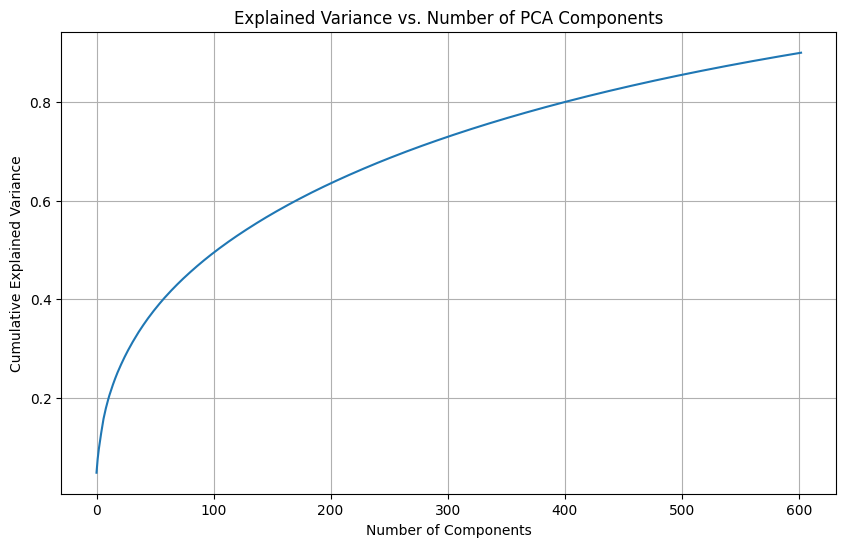

In [10]:
# 1. Load and preprocess data
# In this version, we set the explain variance threshold to 0.90, you can change it in the apply_pca function (variance_thresholds parameter)
try:
    X_train_of, X_val_of, test_of, train_conn, val_conn, test_conn, y_train_sex, y_val_sex, y_train_adhd, y_val_adhd = load_and_preprocess_data()
except Exception as e:
    print(f"Failed to load data: {e}")
    
# 2. Apply PCA for dimensionality reduction
X_train_pca, X_val_pca, X_test_pca, best_pca = apply_pca(train_conn, val_conn, test_conn)
    
#3. Create final feature set
X_train_final, X_val_final, X_test_final, train_ids, val_ids, test_ids = create_final_features(
    X_train_of, X_val_of, test_of, X_train_pca, X_val_pca, X_test_pca)

Loading datasets...
Data loaded successfully.

Applying PCA dimensionality reduction...
  PCA with 0.9 variance threshold: 603 components, 0.9003 explained variance
Selected PCA with 603 components, explaining 0.9003 of variance
Final feature set: 751 features


'\ndef objective(trial):\n    # Define model with hyperparameters to optimize\n\n    tol = trial.suggest_float(\'tol\', 1e-4, 1e-3, log=True)\n    solver = trial.suggest_categorical(\'solver\', [\'liblinear\', \'saga\'])\n    penalty = trial.suggest_categorical(\'penalty\', [\'l1\', \'l2\'])\n    class_weight = {\n            0: trial.suggest_float(\'class_weight_0\', 0, 1),\n            1: trial.suggest_float(\'class_weight_1\', 2, 5)\n        }\n        \n    # liblinear supports both l1 and l2, saga supports both\n    if solver == \'liblinear\' and penalty == \'elasticnet\':\n        penalty = \'l2\'\n            \n    model = LogisticRegression(\n        tol=tol, \n        solver=solver,\n        penalty=penalty,\n        class_weight=class_weight,\n        max_iter=10000\n        )\n    model.fit(X_train_final, y_train_sex)\n    y_pred = model.predict(X_val_final)\n    precision = precision_score(y_val_sex, y_pred, pos_label=1)\n        \n    return precision\n    \n    # Create a

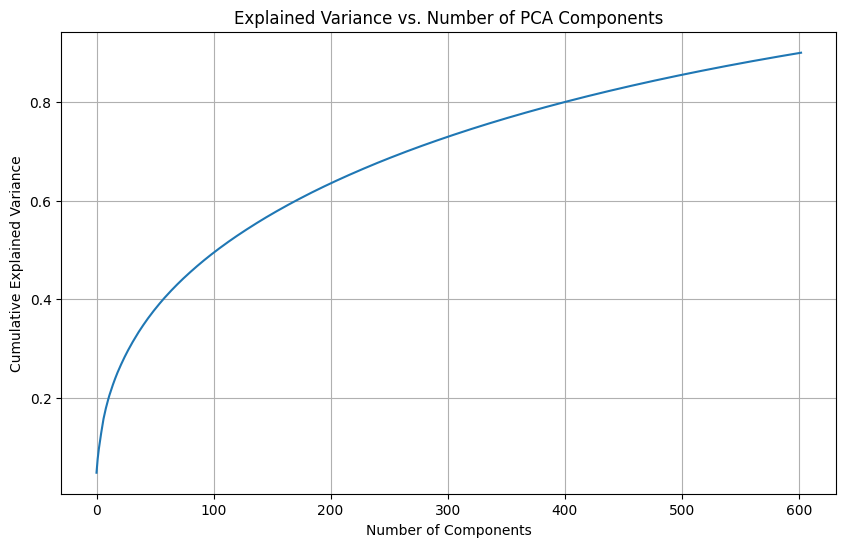

In [ ]:
def objective(trial):
    # Define model with hyperparameters to optimize

    #Below is our final settings for the parameters of the models
    tol = trial.suggest_float('tol', 1e-4, 1e-3, log=True)
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    class_weight = {
            0: trial.suggest_float('class_weight_0', 0, 1),
            1: trial.suggest_float('class_weight_1', 2, 5)
        }
        
    # liblinear supports both l1 and l2, saga supports both
    if solver == 'liblinear' and penalty == 'elasticnet':
        penalty = 'l2'
            
    model = LogisticRegression(
        tol=tol, 
        solver=solver,
        penalty=penalty,
        class_weight=class_weight,
        max_iter=10000
        )
    model.fit(X_train_final, y_train_sex)
    y_pred = model.predict(X_val_final)
    precision = precision_score(y_val_sex, y_pred, pos_label=1) #you can change the evaluation metric here, I have used f1-score and precision_score
        
    return precision
    
    # Create and run Optuna study
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(objective, n_trials=50)
    
    # Get best parameters
best_trial = study.best_trial
best_params = best_trial.params
best_f1 = best_trial.value
    
print(f"Best hyperparameters found: {best_params}")
print(f"Best validation F1 score: {best_f1:.4f}")

In [14]:
#best_params= {'tol': 0.0009552550919481883, 'solver': 'saga', 'penalty': 'l1', 'class_weight': {0: 0.8268882150874972, 1: 5.454939805983347}} #best parameters generated by Optuna 
best_params= {'tol': 0.00042614864894321665, 'solver': 'liblinear', 'penalty': 'l1', 'class_weight':{0: 0.6285471305471457, 1: 3.6596767216462003}}
model = LogisticRegression(**best_params, max_iter=10000)

# Fit the best model on the combined data
model.fit(X_train_final, y_train_sex)

y_val_pred_sex = model.predict(X_val_final)
print(classification_report(y_val_sex, y_val_pred_sex))

              precision    recall  f1-score   support

           0       0.81      0.82      0.81       165
           1       0.61      0.59      0.60        78

    accuracy                           0.74       243
   macro avg       0.71      0.70      0.71       243
weighted avg       0.74      0.74      0.74       243



In [ ]:
y_test_prob_sex=model.predict_proba(X_test_final)
y_test_prob_sex

array([[9.25476337e-01, 7.45236629e-02],
       [2.68373155e-01, 7.31626845e-01],
       [8.37287427e-01, 1.62712573e-01],
       [2.00433601e-02, 9.79956640e-01],
       [9.96931469e-01, 3.06853089e-03],
       [5.08965248e-02, 9.49103475e-01],
       [9.96009563e-01, 3.99043664e-03],
       [3.49641300e-01, 6.50358700e-01],
       [9.98318983e-01, 1.68101698e-03],
       [3.56640113e-05, 9.99964336e-01],
       [9.99977524e-01, 2.24756514e-05],
       [9.98483416e-01, 1.51658410e-03],
       [9.99992904e-01, 7.09640649e-06],
       [9.64703244e-01, 3.52967563e-02],
       [9.99998264e-01, 1.73645490e-06],
       [9.79926138e-01, 2.00738618e-02],
       [1.21247509e-03, 9.98787525e-01],
       [9.99807306e-01, 1.92694358e-04],
       [5.06830109e-01, 4.93169891e-01],
       [1.00000000e+00, 4.01262113e-10],
       [5.96433368e-04, 9.99403567e-01],
       [8.75045812e-01, 1.24954188e-01],
       [3.50422345e-01, 6.49577655e-01],
       [9.92364497e-01, 7.63550336e-03],
       [1.191563

In [ ]:
#set lower threshold for positive class prediction
threshold = 0.00015
y_test_pred_sex= (y_test_prob_sex >= threshold).astype(int)
y_test_pred_sex[:,1]
np.mean(y_test_pred_sex[:,1]) #percentage of positive class

np.float64(0.7138157894736842)

In [ ]:
sex_predictions = save_predictions(test_ids, y_test_pred_sex, "sex_predictions.csv")

In [160]:
adhd['Sex_F']=sex['Sex_F']
adhd.drop(['prediction'], inplace=True, axis=1)
adhd.set_index(['participant_id'], inplace=True)
adhd.to_csv('submission_adhd_xgb35.csv', index=True)

## ADHD classification tuning with ensemble

In [22]:
from xgboost import XGBClassifier

In [23]:
# You can try adding polynomial features or not
def polynomial_features(X):
    """Generate polynomial features."""
    X['SDQ_SDQ_Hyperactivity^2'] = X['SDQ_SDQ_Hyperactivity']**2
    X['SDQ_SDQ_Hyperactivity^3'] = X['SDQ_SDQ_Hyperactivity']**3
    X['Hyperactivity*Externalizing'] = X['SDQ_SDQ_Hyperactivity'] * X['SDQ_SDQ_Externalizing']
    X['Hyperactivity*Total_Problems'] = X['SDQ_SDQ_Hyperactivity'] * X['SDQ_Total_Problems']
    
    return X

X_train_final = polynomial_features(X_train_final)
X_val_final = polynomial_features(X_val_final)
X_test_final = polynomial_features(X_test_final)

In [ ]:
def objective(trial):
    # Define model with hyperparameters to optimize

    n_estimators = trial.suggest_int('n_estimators', 150, 350)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, log=True)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 5, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 12)
    subsample = trial.suggest_float('subsample', 0.5, 1.0) #try adding gamma, scale_pos_weight.
            
    model = XGBClassifier(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                subsample=subsample,
                random_state=42
            )

    model.fit(X_train_final, y_train_adhd)
    y_pred = model.predict(X_val_final)
    precision = precision_score(y_val_adhd, y_pred, pos_label=1)
        
    return precision
    
    # Create and run Optuna study
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(objective, n_trials=20)
    
    # Get best parameters
best_trial = study.best_trial
best_params = best_trial.params
best_f1 = best_trial.value
    
print(f"Best hyperparameters found: {best_params}")
print(f"Best validation F1 score: {best_f1:.4f}")

In the final version, I have tried using GradientBoosting so it might lack some parameters I used in XGBoost. Much difference from tuning with RandomForest.

In [25]:
model = XGBClassifier(**{'n_estimators': 234, 'learning_rate': 0.04318732260577454, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 6, 'subsample': 0.6258186302010473}, gamma = 0.5, scale_pos_weight=1.0, use_label_encoder=False, eval_metric='logloss', random_state=42)

In [26]:
#best_params = {'n_estimators': 278, 'learning_rate': 0.025066967201269497, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 5, 'subsample': 0.8246000284280394}
#best_params ={'n_estimators': 234, 'learning_rate': 0.04318732260577454, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 6, 'subsample': 0.6258186302010473}
#best_params= {'n_estimators': 221, 'learning_rate': 0.018169394784130256, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 4, 'subsample': 0.8458860286792633}
#model = GradientBoostingClassifier(**best_params, random_state=42)

model.fit(X_train_final, y_train_adhd)
y_val_pred_adhd = model.predict(X_val_final)
print(classification_report(y_val_adhd, y_val_pred_adhd))

              precision    recall  f1-score   support

           0       0.67      0.71      0.69        75
           1       0.87      0.85      0.86       168

    accuracy                           0.80       243
   macro avg       0.77      0.78      0.77       243
weighted avg       0.81      0.80      0.80       243



In [ ]:
y_val_prob_adhd=model.predict_proba(X_val_final)[:,1]

In [ ]:
# Setting a threshold on validation set
threshold = 0.35
y_pred = (y_val_prob_adhd >= threshold).astype(int)

print("Precision class 1:", precision_score(y_val_adhd, y_pred, pos_label=1))
print(classification_report(y_val_adhd, y_pred))

Precision class 1: 0.8153846153846154
              precision    recall  f1-score   support

           0       0.81      0.52      0.63        75
           1       0.82      0.95      0.88       168

    accuracy                           0.81       243
   macro avg       0.81      0.73      0.76       243
weighted avg       0.81      0.81      0.80       243



In [28]:
y_test_adhd=model.predict_proba(X_test_final)
#setting threshold on test set
threshold = 0.35
y_test_pred= (y_test_adhd >= threshold).astype(int)
y_test_pred[:,1]
np.mean(y_test_pred[:,1])

np.float64(0.7664473684210527)

In [ ]:
adhd_predict= save_predictions(test_ids, y_test_pred[:,1], "adhd_predictions.csv")


Saving predictions to adhd_predictions.csv...
Predictions saved to adhd_predictions.csv


In [ ]:
adhd=pd.read_csv('adhd_predictions.csv')
sex=pd.read_csv('sex_predictions.csv')
adhd['ADHD_Outcome']=adhd['prediction']
adhd['Sex_F']=sex['prediction']

In [ ]:
adhd['Sex_F']=sex['Sex_F']
adhd.drop(['prediction'], inplace=True, axis=1)
adhd.set_index(['participant_id'], inplace=True)
#submission file
adhd.to_csv('submission_adhd_xgb35.csv', index=True)